In [1]:
import os,cv2,torch,torchvision
import detectron2
from detectron2.evaluation import COCOEvaluator,inference_context,inference_on_dataset
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog,MetadataCatalog,build_detection_test_loader
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.model_zoo import get_checkpoint_url,get_config_file
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import Visualizer,BoxMode
import numpy as np
import pandas as pd
from tqdm import tqdm
from xml.etree import ElementTree

In [2]:
imgs = []
x_mins = []
y_mins = []
y_maxs = []
x_maxs = []

In [3]:
for img in zip(os.listdir('./data/')):
    try:
        img = img[0]
        tree = ElementTree.parse(f'./data/{img}')
        root = tree.getroot()
        for box in root.findall('.//bndbox'):
            xmin = box.find('xmin').text
            xmax = box.find('xmax').text
            ymin = box.find('ymin').text
            ymax = box.find('ymax').text
        imgs.append('./data/' + img.replace('.xml','.jpg'))
        x_mins.append(int(xmin))
        x_maxs.append(int(xmax))
        y_mins.append(int(ymin))
        y_maxs.append(int(ymax))
    except Exception as e:
        pass

In [4]:
data = pd.DataFrame({'frame':imgs,'xmin':x_mins,'xmax':x_maxs,'ymax':y_maxs,'ymin':y_mins})

In [5]:
def load_data(data=data):
    dataset = []
    for idx in tqdm(range(len(data))):
        record = {}
        info = data.iloc[idx]
        xmin,ymin,xmax,ymax = info['xmin'],info['ymin'],info['xmax'],info['ymax']
        height,width = cv2.imread(info['frame']).shape[:2]
        record['file_name'] = info['frame']
        record['height'] = height
        record['width'] = width
        info['class_id'] = 0
        record['cateogry_id'] = 0
        objs = [{'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],'bbox_mode':BoxMode.XYXY_ABS,'iscrowd':0,'category_id':0}]
        record['image_id'] = idx
        record['annotations'] = objs
        record['class_id'] = 0
        record['xmin'] = xmin
        record['ymin'] = ymin
        record['xmax'] = xmax
        record['ymax'] = ymax
        dataset.append(record)
    return dataset

In [6]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=['PathHole'])
metadata = MetadataCatalog.get('data')

In [7]:
import wandb


In [8]:
import matplotlib.pyplot as plt


In [9]:
# torch.cuda.empty_cache()
# wandb.init(sync_tensorboard=True,name='baseline')
# model = 'COCO-Detection/faster_rcnn_R_50_C4_1x.yaml'
# cfg = get_cfg()
# cfg.merge_from_file(get_config_file(model))
# cfg.DATASETS.TRAIN = ('data',)
# cfg.DATASETS.TEST = ()
# cfg.MODEL.WEIGHTS = get_checkpoint_url(model)
# cfg.SOLVER.MAX_ITER = 2500 + 1250
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.STEPS = []
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(['PathHole'])
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.475
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# img = cv2.imread('./data/img-1.jpg')
# predictor = DefaultPredictor(cfg)
# preds = predictor(img)['instances'].to('cpu')
# v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
# v = v.draw_instance_predictions(preds)
# v = v.get_image()[:,:,::-1]
# wandb.log({'img':wandb.Image(v)})
# plt.figure(figsize=(10,7))
# plt.imshow(v)
# plt.show()

In [10]:
# from detectron2.checkpoint import DetectionCheckpointer
# checkpointer = DetectionCheckpointer(model, save_dir="output")
# checkpointer.save("model_999") 

In [11]:
models = [
    'COCO-Detection/faster_rcnn_R_101_C4_3x.yaml',
    'COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml',
    'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
    'COCO-Detection/faster_rcnn_R_50_C4_1x.yaml',
    'COCO-Detection/faster_rcnn_R_50_C4_3x.yaml',
    'COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml',
    'COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml',
    'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
    'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
    'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
    'COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml'
]

In [12]:
BASE_LRS = [
    0.00025,
    0.00050,
    0.00075,
    0.0001,
    0.001,
    0.01,
    0.0002,
    0.0003,
    0.0004,
    0.0005,
    0.0006,
    0.0007,
    0.0008,
    0.0009,
]

In [13]:
IMS_PER_BATCHS = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]

In [14]:
BATCH_SIZE_PER_IMAGES = [
    121,
    122,
    123,
    124,
    125,
    126,
    127,
    129
]

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[08/28 08:35:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

  0%|          | 0/665 [00:00<?, ?it/s]/home/indika/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/home/indika/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
100%|██████████| 665/665 [00:02<00:00, 311.75it/s]

[08/28 08:35:54 d2.data.build]: Removed 0 images with no usable annotations. 665 images left.
[08/28 08:35:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  PathHole  | 665          |
|            |              |
[08/28 08:35:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/28 08:35:54 d2.data.build]: Using training sampler TrainingSampler
[08/28 08:35:54 d2.data.common]: Serializing 665 elements to byte tensors and concatenating them all ...
[08/28 08:35:54 d2.data.common]: Serialized dataset takes 0.27 MiB



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[08/28 08:35:54 d2.engine.train_loop]: Starting training from iteration 0


/home/indika/anaconda3/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[08/28 08:36:04 d2.utils.events]:  eta: 0:29:07  iter: 19  total_loss: 1.129  loss_cls: 0.6177  loss_box_reg: 0.2202  loss_rpn_cls: 0.1677  loss_rpn_loc: 0.01343  time: 0.4702  data_time: 0.0208  lr: 4.9953e-06  max_mem: 3071M
[08/28 08:36:14 d2.utils.events]:  eta: 0:29:02  iter: 39  total_loss: 0.9996  loss_cls: 0.5538  loss_box_reg: 0.1576  loss_rpn_cls: 0.2135  loss_rpn_loc: 0.02457  time: 0.4726  data_time: 0.0029  lr: 9.9902e-06  max_mem: 3071M
[08/28 08:36:23 d2.utils.events]:  eta: 0:29:11  iter: 59  total_loss: 0.956  loss_cls: 0.4154  loss_box_reg: 0.1781  loss_rpn_cls: 0.2733  loss_rpn_loc: 0.02565  time: 0.4747  data_time: 0.0028  lr: 1.4985e-05  max_mem: 3176M
[08/28 08:36:33 d2.utils.events]:  eta: 0:29:28  iter: 79  total_loss: 0.758  loss_cls: 0.3635  loss_box_reg: 0.2381  loss_rpn_cls: 0.1366  loss_rpn_loc: 0.0196  time: 0.4759  data_time: 0.0026  lr: 1.998e-05  max_mem: 3176M
[08/28 08:36:43 d2.utils.events]:  eta: 0:29:10  iter: 99  total_loss: 0.8377  loss_cls: 0.29

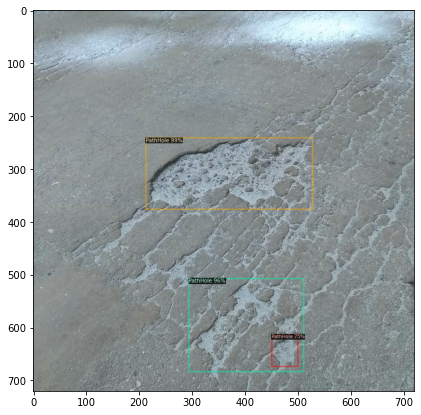

global_step,3749
_timestamp,1630121756.76821
rpn/num_pos_anchors,20.25
rpn/num_neg_anchors,235.75
roi_head/num_fg_samples,18.75
roi_head/num_bg_samples,109.25
fast_rcnn/cls_accuracy,0.98047
fast_rcnn/fg_cls_accuracy,0.97368
fast_rcnn/false_negative,0.02632
data_time,0.00288
total_loss,0.19374


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
rpn/num_pos_anchors,▂▃▁▃▄▁▂▅▂▃▄▃▃▁▄▆▇▂▄▂▄▃▃▂▃▃▂▃▃▂▅▃▃▂▆▂▂▃▃█
rpn/num_neg_anchors,▇▆█▆▅█▇▄▇▆▅▆▆█▅▃▂▇▅▇▅▆▆▇▆▆▇▆▆▇▄▆▆▇▃▇▇▆▆▁
roi_head/num_fg_samples,▁▃▃▅▅▅▄▇▆▅▆▆▆▆▇▆▇▆▆▅▆▅▆▇▆▇▇▇▇█▇▇▆▇▇▆▆▇▇▇
roi_head/num_bg_samples,█▆▆▄▄▄▅▂▃▄▃▃▃▃▂▃▂▃▃▄▃▄▃▂▃▂▂▂▂▁▂▂▃▂▂▃▃▂▂▂
fast_rcnn/cls_accuracy,▁▃▂▂▄▅▄▅▅▄▆▇▆▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
fast_rcnn/fg_cls_accuracy,▁▁▁▃▅▆▇▇▇▆▇█▇▇█▇█▇▇████▇▇███████████████
fast_rcnn/false_negative,███▆▄▃▂▂▂▃▂▁▂▂▁▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
data_time,▄▂▄▆▃▃▃▂▃▅▄▄▆▆▁▄▃▇▄▅▄▇▅▃█▅▄▃▅▃▂▃▅▃▄▅▄▅▁▄
total_loss,█▆▅▅▅▄▄▃▃▂▃▂▂▂▂▂▂▃▂▁▂▂▁▂▂▁▂▂▁▂▁▂▁▂▁▁▁▁▁▁


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[08/28 09:06:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

100%|██████████| 665/665 [00:02<00:00, 299.42it/s]

[08/28 09:06:27 d2.data.build]: Removed 0 images with no usable annotations. 665 images left.
[08/28 09:06:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/28 09:06:27 d2.data.build]: Using training sampler TrainingSampler
[08/28 09:06:27 d2.data.common]: Serializing 665 elements to byte tensors and concatenating them all ...
[08/28 09:06:27 d2.data.common]: Serialized dataset takes 0.27 MiB



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[08/28 09:06:31 d2.engine.train_loop]: Starting training from iteration 0
[08/28 09:06:42 d2.utils.events]:  eta: 0:34:21  iter: 19  total_loss: 1.133  loss_cls: 0.5522  loss_box_reg: 0.1628  loss_rpn_cls: 0.286  loss_rpn_loc: 0.01801  time: 0.5819  data_time: 0.0112  lr: 4.9953e-06  max_mem: 4907M
[08/28 09:06:55 d2.utils.events]:  eta: 0:36:06  iter: 39  total_loss: 1.041  loss_cls: 0.4855  loss_box_reg: 0.1563  loss_rpn_cls: 0.3604  loss_rpn_loc: 0.02548  time: 0.6088  data_time: 0.0028  lr: 9.9902e-06  max_mem: 4907M
[08/28 09:07:07 d2.utils.events]:  eta: 0:37:10  iter: 59  total_loss: 0.9231  loss_cls: 0.4055  loss_box_reg: 0.2435  loss_rpn_cls: 0.2894  loss_rpn_loc: 0.02907  time: 0.6125  data_time: 0.0031  lr: 1.4985e-05  max_mem: 4990M
[08/28 09:07:19 d2.utils.events]:  eta: 0:36:58  iter: 79  total_loss: 0.8673  loss_cls: 0.3616  loss_box_reg: 0.2434  loss_rpn_cls: 0.1112  loss_rpn_loc: 0.02061  time: 0.6085  data_time: 0.0027  lr: 1.998e-05  max_mem: 4990M
[08/28 09:07:32 d2

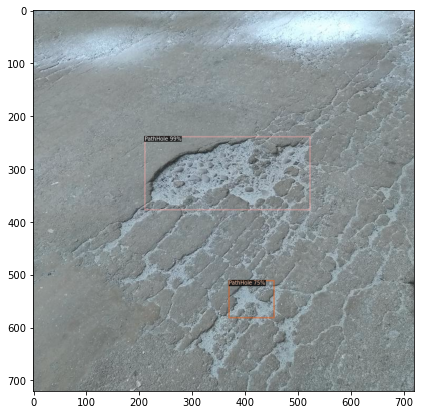

global_step,3749
_timestamp,1630124074.4212
rpn/num_pos_anchors,8.0
rpn/num_neg_anchors,248.0
roi_head/num_fg_samples,18.75
roi_head/num_bg_samples,109.25
fast_rcnn/cls_accuracy,0.98438
fast_rcnn/fg_cls_accuracy,0.9619
fast_rcnn/false_negative,0.0381
data_time,0.00286
total_loss,0.2011


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
rpn/num_pos_anchors,▄▇▄▅▅▄▄█▅▃▂▄▂▃▆▃▃▆▄▃▃▃▅▄▄▄▂▆▃▄▄▃▃▃▆▄▅▂▁▃
rpn/num_neg_anchors,▅▂▅▄▄▅▅▁▄▆▇▅▇▆▃▆▆▃▅▆▆▆▄▅▅▅▇▃▆▅▅▆▆▆▃▅▄▇█▆
roi_head/num_fg_samples,▁▄▅▅▆▇▆▅▆▅▅▇█▅▇▇▅▇█▇▇██▇▇▆█▇██▇█▇▇▇▇█▆██
roi_head/num_bg_samples,█▅▄▄▃▂▃▄▃▄▄▂▁▄▂▂▄▂▁▂▂▁▁▂▂▃▁▂▁▁▂▁▂▂▂▂▁▃▁▁
fast_rcnn/cls_accuracy,▅▂▁▁▄▄▅▅▆▆▆▇▆▇▆▇▆▇▇▆▆▇██▇████▇▇▇▇█▇█████
fast_rcnn/fg_cls_accuracy,▁▁▁▁▄▅▆▆▇▆▆▇▇▇▇▇▇▇█▇▇███▇█████▇█████████
fast_rcnn/false_negative,████▅▄▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
data_time,▆▅▆▆▁▆▅▄▇▄▄▆▂▆▃▃█▆▄▆▅▅▅▆▂▇▅▅▇▂█▆▄█▂▅▇▄▄▆
total_loss,█▆▆▆▅▅▄▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[08/28 09:44:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 665/665 [00:02<00:00, 295.48it/s]

[08/28 09:45:00 d2.data.build]: Removed 0 images with no usable annotations. 665 images left.


[08/28 09:45:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/28 09:45:00 d2.data.build]: Using training sampler TrainingSampler
[08/28 09:45:00 d2.data.common]: Serializing 665 elements to byte tensors and concatenating them all ...
[08/28 09:45:00 d2.data.common]: Serialized dataset takes 0.27 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[08/28 09:45:02 d2.engine.train_loop]: Starting training from iteration 0
[08/28 09:45:11 d2.utils.events]:  eta: 0:30:15  iter: 19  total_loss: 0.9028  loss_cls: 0.611  loss_box_reg: 0.159  loss_rpn_cls: 0.07414  loss_rpn_loc: 0.01033  time: 0.4416  data_time: 0.0121  lr: 4.9953e-06  max_mem: 4990M
[08/28 09:45:19 d2.utils.events]:  eta: 0:25:29  iter: 39  total_loss: 0.7988  loss_cls: 0.5474  loss_box_reg: 0.1327  loss_rpn_cls: 0.09604  loss_rpn_loc: 0.008302  time: 0.4271  data_time: 0.0028  lr: 9.9902e-06  max_mem: 4990M
[08/28 09:45:27 d2.utils.events]:  eta: 0:25:11  iter: 59  total_loss: 0.7451  loss_cls: 0.4412  loss_box_reg: 0.2215  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.009038  time: 0.4224  data_time: 0.0029  lr: 1.4985e-05  max_mem: 4990M
[08/28 09:45:36 d2.utils.events]:  eta: 0:25:04  iter: 79  total_loss: 0.6979  loss_cls: 0.3427  loss_box_reg: 0.1473  loss_rpn_cls: 0.1034  loss_rpn_loc: 0.009785  time: 0.4208  data_time: 0.0031  lr: 1.998e-05  max_mem: 4990M
[08/28 09:4

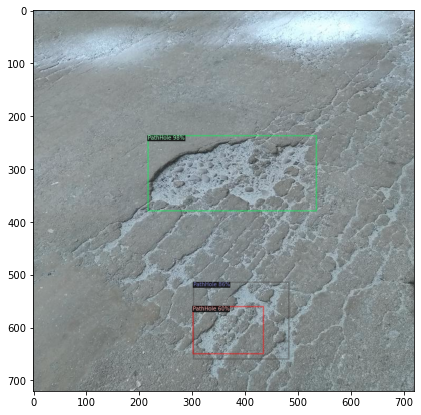

global_step,3749
_timestamp,1630125647.16033
rpn/num_pos_anchors,4.0
rpn/num_neg_anchors,252.0
roi_head/num_fg_samples,19.5
roi_head/num_bg_samples,108.5
fast_rcnn/cls_accuracy,0.9668
fast_rcnn/fg_cls_accuracy,0.9166
fast_rcnn/false_negative,0.0834
data_time,0.00279
total_loss,0.23695


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
rpn/num_pos_anchors,▃▅▃▅▆▇▅▅▅▄▇▁▅▃▃▅▅█▃▆▅▇▅▅▄▃█▅▇▅▃▃▃█▃▄▆▅▃▅
rpn/num_neg_anchors,▆▄▆▅▃▂▅▅▅▅▂█▅▆▆▄▄▁▆▃▅▂▄▄▅▆▁▅▂▅▆▆▆▁▆▅▃▄▆▅
roi_head/num_fg_samples,▁▂▃▄▅▃▃▆▆▅▄▆▆▅▆▅▆▇▆█▆▇▇▆▇▇▇▆▇▇▇▆████▇█▇█
roi_head/num_bg_samples,█▇▅▅▅▅▆▃▃▄▅▃▃▄▃▄▃▂▃▁▃▂▂▃▂▂▂▃▂▂▂▃▁▁▁▁▂▁▂▁
fast_rcnn/cls_accuracy,▁▅▄▃▃▅▆▆▆▆▆▆▆▆▆▆▇▆▆▅▆▇▇▆▇▇▆▇█▇▇▇▇▇▇██▇▇▇
fast_rcnn/fg_cls_accuracy,▁▁▁▁▁▃▄▆▅▆▆▇▆▆▇▆▇▆▇▆▇▇▇▇███▇███▇████████
fast_rcnn/false_negative,█████▆▅▃▄▃▃▂▃▃▂▃▂▃▂▃▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
data_time,▄▄▃▄▅▆▃▃▅▅▃▁▆▄▄▅▄▅▇█▅▄▄▅▅▅▄▄▄▄▃▃▄▅▅▄▂▃▆▄
total_loss,█▅▆▆▆▄▄▃▃▂▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▂▂▁▁▂▂▁


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[08/28 10:11:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

100%|██████████| 665/665 [00:02<00:00, 301.23it/s]

[08/28 10:11:20 d2.data.build]: Removed 0 images with no usable annotations. 665 images left.


[08/28 10:11:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/28 10:11:20 d2.data.build]: Using training sampler TrainingSampler
[08/28 10:11:20 d2.data.common]: Serializing 665 elements to byte tensors and concatenating them all ...
[08/28 10:11:20 d2.data.common]: Serialized dataset takes 0.27 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[08/28 10:11:21 d2.engine.train_loop]: Starting training from iteration 0
[08/28 10:11:29 d2.utils.events]:  eta: 0:22:23  iter: 19  total_loss: 1.246  loss_cls: 0.7143  loss_box_reg: 0.2094  loss_rpn_cls: 0.2212  loss_rpn_loc: 0.0381  time: 0.3670  data_time: 0.0118  lr: 4.9953e-06  max_mem: 4990M
[08/28 10:11:36 d2.utils.events]:  eta: 0:22:16  iter: 39  total_loss: 0.9979  loss_cls: 0.6283  loss_box_reg: 0.1653  loss_rpn_cls: 0.1347  loss_rpn_loc: 0.01159  time: 0.3570  data_time: 0.0025  lr: 9.9902e-06  max_mem: 4990M
[08/28 10:11:43 d2.utils.events]:  eta: 0:22:08  iter: 59  total_loss: 0.7919  loss_cls: 0.4747  loss_box_reg: 0.1559  loss_rpn_cls: 0.1104  loss_rpn_loc: 0.01298  time: 0.3560  data_time: 0.0029  lr: 1.4985e-05  max_mem: 4990M
[08/28 10:11:50 d2.utils.events]:  eta: 0:21:40  iter: 79  total_loss: 0.8869  loss_cls: 0.3921  loss_box_reg: 0.2463  loss_rpn_cls: 0.2118  loss_rpn_loc: 0.03794  time: 0.3559  data_time: 0.0029  lr: 1.998e-05  max_mem: 4990M
[08/28 10:11:57 d

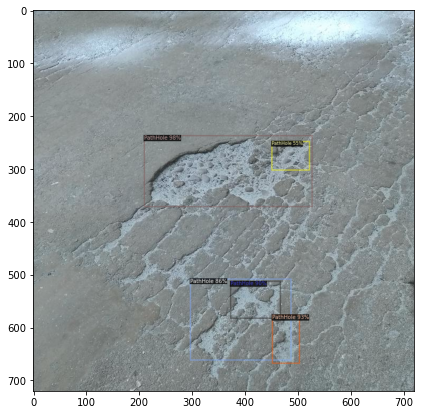

global_step,3749
_timestamp,1630127019.91745
rpn/num_pos_anchors,6.5
rpn/num_neg_anchors,249.5
roi_head/num_fg_samples,18.0
roi_head/num_bg_samples,110.0
fast_rcnn/cls_accuracy,0.96484
fast_rcnn/fg_cls_accuracy,0.93203
fast_rcnn/false_negative,0.06797
data_time,0.00295
total_loss,0.29625


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
rpn/num_pos_anchors,▂▃▄▂▂▃▃▄▃▂▄▁▂▃▃▁▄▂▂▂▄▂▃▂▅█▃▂▄▃▃▅▂▂▃▆▃▃▄▂
rpn/num_neg_anchors,▇▆▅▇▇▆▆▅▆▇▅█▇▆▆█▅▇▇▇▅▇▆▇▄▁▆▇▅▆▆▄▇▇▆▃▆▆▅▇
roi_head/num_fg_samples,▁▃▃▅▄▅▅▃▅▅▅▆▆▅▆▅▅▅▇▆▇▇▇▅▆▇▇▇▇▇▇█▇▆▇▇▆█▇▇
roi_head/num_bg_samples,█▆▆▅▅▄▄▆▄▄▄▃▃▄▃▄▄▄▂▃▂▂▂▄▃▂▂▂▂▂▂▁▂▃▂▂▃▁▂▂
fast_rcnn/cls_accuracy,▁▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇██▇█████▇███
fast_rcnn/fg_cls_accuracy,▁▁▁▁▁▂▆▆▆▇▇▇▇▆▇▅▆▇▇▇█▇▇▇▇▇▇▇██▇██▇██▇███
fast_rcnn/false_negative,█████▇▃▃▃▂▂▂▂▃▂▄▃▂▂▂▁▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁
data_time,▁▆▅▆██▅▆▅▆▇▆▆▆▅▆▆▇█▄▇▆▃▅▃▇▅▆▆▆█▃▆▇▆▆▅█▅▇
total_loss,█▅▅▅▅▅▄▃▃▃▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[08/28 10:34:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

100%|██████████| 665/665 [00:02<00:00, 298.36it/s]

[08/28 10:34:02 d2.data.build]: Removed 0 images with no usable annotations. 665 images left.
[08/28 10:34:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/28 10:34:02 d2.data.build]: Using training sampler TrainingSampler
[08/28 10:34:02 d2.data.common]: Serializing 665 elements to byte tensors and concatenating them all ...
[08/28 10:34:02 d2.data.common]: Serialized dataset takes 0.27 MiB



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[08/28 10:34:03 d2.engine.train_loop]: Starting training from iteration 0
[08/28 10:34:10 d2.utils.events]:  eta: 0:20:38  iter: 19  total_loss: 1.308  loss_cls: 0.9256  loss_box_reg: 0.179  loss_rpn_cls: 0.1342  loss_rpn_loc: 0.01386  time: 0.3525  data_time: 0.0113  lr: 4.9953e-06  max_mem: 4990M
[08/28 10:34:17 d2.utils.events]:  eta: 0:20:14  iter: 39  total_loss: 1.243  loss_cls: 0.7888  loss_box_reg: 0.1979  loss_rpn_cls: 0.179  loss_rpn_loc: 0.0241  time: 0.3479  data_time: 0.0030  lr: 9.9902e-06  max_mem: 4990M
[08/28 10:34:24 d2.utils.events]:  eta: 0:20:27  iter: 59  total_loss: 1.037  loss_cls: 0.5338  loss_box_reg: 0.3009  loss_rpn_cls: 0.1703  loss_rpn_loc: 0.01825  time: 0.3507  data_time: 0.0028  lr: 1.4985e-05  max_mem: 4990M
[08/28 10:34:32 d2.utils.events]:  eta: 0:21:18  iter: 79  total_loss: 0.8141  loss_cls: 0.3945  loss_box_reg: 0.2192  loss_rpn_cls: 0.1805  loss_rpn_loc: 0.01942  time: 0.3567  data_time: 0.0031  lr: 1.998e-05  max_mem: 4990M
[08/28 10:34:39 d2.ut

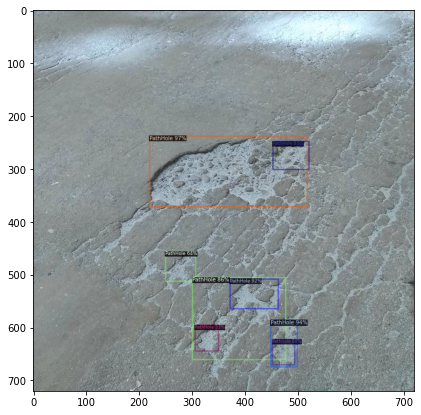

global_step,3749
_timestamp,1630128377.40388
rpn/num_pos_anchors,6.0
rpn/num_neg_anchors,250.0
roi_head/num_fg_samples,19.0
roi_head/num_bg_samples,109.0
fast_rcnn/cls_accuracy,0.97266
fast_rcnn/fg_cls_accuracy,0.9057
fast_rcnn/false_negative,0.0943
data_time,0.00315
total_loss,0.27265


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
rpn/num_pos_anchors,▂▂▃▁▂▄▂▂▅▃▃▂▄▂▂▂▂▄▃▃▃▃▂▃█▁▂▂▃▁▁▄▂▂▃▁▃▃▄▁
rpn/num_neg_anchors,▇▇▆█▇▅▇▇▄▆▆▇▅▇▇▇▇▅▆▆▆▆▇▆▁█▇▇▆██▅▇▇▆█▆▆▅█
roi_head/num_fg_samples,▁▂▃▃▄▄▄▅▅▄▅▄▅▅▇▆▆▇▇▆▆▅▅▆▇▆▇▆█▆▅▆▆▆▇▅▇█▆▇
roi_head/num_bg_samples,█▇▆▆▅▅▅▄▄▅▄▅▄▄▂▃▃▂▂▃▃▄▄▃▂▃▂▃▁▃▄▃▃▃▂▄▂▁▃▂
fast_rcnn/cls_accuracy,▁█▇▇████████████████████████████████████
fast_rcnn/fg_cls_accuracy,▄▁▁▁▂▄▅▇▆▇▇▇▇▇▇▇▇▇█▇█▇██▇█▇▇██▇█▇███████
fast_rcnn/false_negative,▅███▇▅▄▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁
data_time,▆▆▁▄▅▅▅▁▇▃▅▆▃▇▅▆▃▄▇▆▄▇▄█▄▅▆▄▄▇▅▅▅▅▃▄▂▆▇█
total_loss,█▄▅▄▄▄▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[08/28 10:56:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

100%|██████████| 665/665 [00:02<00:00, 307.02it/s]

[08/28 10:56:53 d2.data.build]: Removed 0 images with no usable annotations. 665 images left.
[08/28 10:56:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/28 10:56:53 d2.data.build]: Using training sampler TrainingSampler
[08/28 10:56:53 d2.data.common]: Serializing 665 elements to byte tensors and concatenating them all ...


[08/28 10:56:53 d2.data.common]: Serialized dataset takes 0.27 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[08/28 10:56:56 d2.engine.train_loop]: Starting training from iteration 0
[08/28 10:57:05 d2.utils.events]:  eta: 0:25:55  iter: 19  total_loss: 1.087  loss_cls: 0.6901  loss_box_reg: 0.1657  loss_rpn_cls: 0.1606  loss_rpn_loc: 0.01013  time: 0.4715  data_time: 0.0127  lr: 4.9953e-06  max_mem: 4990M
[08/28 10:57:15 d2.utils.events]:  eta: 0:28:26  iter: 39  total_loss: 1.215  loss_cls: 0.6129  loss_box_reg: 0.2343  loss_rpn_cls: 0.2938  loss_rpn_loc: 0.05613  time: 0.4851  data_time: 0.0041  lr: 9.9902e-06  max_mem: 4990M
[08/28 10:57:25 d2.utils.events]:  eta: 0:30:50  iter: 59  total_loss: 0.9761  loss_cls: 0.5116  loss_box_reg: 0.2575  loss_rpn_cls: 0.2229  loss_rpn_loc: 0.02127  time: 0.4950  data_time: 0.0031  lr: 1.4985e-05  max_mem: 4990M
[08/28 10:57:35 d2.utils.events]:  eta: 0:30:40  iter: 79  total_loss: 0.8383  loss_cls: 0.3987  loss_box_reg: 0.2301  loss_rpn_cls: 0.1963  loss_rpn_loc: 0.0284  time: 0.4936  data_time: 0.0030  lr: 1.998e-05  max_mem: 4990M
[08/28 10:57:45 d2

In [ ]:
# for model in models:
#     try:
#         torch.cuda.empty_cache()
#         wandb.init(sync_tensorboard=True,name=model)
#         model = model
#         cfg = get_cfg()
#         cfg.merge_from_file(get_config_file(model))
#         cfg.DATASETS.TRAIN = ('data',)
#         cfg.DATASETS.TEST = ()
#         cfg.MODEL.WEIGHTS = get_checkpoint_url(model)
#         cfg.SOLVER.MAX_ITER = 2500 + 1250
#         cfg.SOLVER.BASE_LR = 0.00025
#         cfg.SOLVER.STEPS = []
#         cfg.SOLVER.IMS_PER_BATCH = 2
#         cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(['PathHole'])
#         cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#         trainer = DefaultTrainer(cfg)
#         trainer.resume_or_load(resume=False)
#         trainer.train()
#         cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.475
#         cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#         img = cv2.imread('./data/img-1.jpg')
#         predictor = DefaultPredictor(cfg)
#         preds = predictor(img)['instances'].to('cpu')
#         v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
#         v = v.draw_instance_predictions(preds)
#         v = v.get_image()[:,:,::-1]
#         wandb.log({'img':wandb.Image(v)})
#         plt.figure(figsize=(10,7))
#         plt.imshow(v)
#         plt.show()
#     except:
#         pass

In [ ]:
# for BASE_LR in BASE_LRS:
#     torch.cuda.empty_cache()
#     wandb.init(sync_tensorboard=True,name=model)
#     model = 
#     cfg = get_cfg()
#     cfg.merge_from_file(get_config_file(model))
#     cfg.DATASETS.TRAIN = ('data',)
#     cfg.DATASETS.TEST = ()
#     cfg.MODEL.WEIGHTS = get_checkpoint_url(model)
#     cfg.SOLVER.MAX_ITER = 2500 + 1250
#     cfg.SOLVER.BASE_LR = BASE_LR
#     cfg.SOLVER.STEPS = []
#     cfg.SOLVER.IMS_PER_BATCH = 2
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(['PathHole'])
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#     trainer = DefaultTrainer(cfg)
#     trainer.resume_or_load(resume=False)
#     trainer.train()
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.475
#     cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#     img = cv2.imread('./data/img-1.jpg')
#     predictor = DefaultPredictor(cfg)
#     preds = predictor(img)['instances'].to('cpu')
#     v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
#     v = v.draw_instance_predictions(preds)
#     v = v.get_image()[:,:,::-1]
#     wandb.log({'img':wandb.Image(v)})
#     plt.figure(figsize=(10,7))
#     plt.imshow(v)
#     plt.show()

In [ ]:
# for IMS_PER_BATCH in IMS_PER_BATCHS:
#     torch.cuda.empty_cache()
#     wandb.init(sync_tensorboard=True,name=model)
#     model = 
#     cfg = get_cfg()
#     cfg.merge_from_file(get_config_file(model))
#     cfg.DATASETS.TRAIN = ('data',)
#     cfg.DATASETS.TEST = ()
#     cfg.MODEL.WEIGHTS = get_checkpoint_url(model)
#     cfg.SOLVER.MAX_ITER = 2500 + 1250
#     cfg.SOLVER.BASE_LR = 
#     cfg.SOLVER.STEPS = []
#     cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(['PathHole'])
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#     trainer = DefaultTrainer(cfg)
#     trainer.resume_or_load(resume=False)
#     trainer.train()
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.475
#     cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#     img = cv2.imread('./data/img-1.jpg')
#     predictor = DefaultPredictor(cfg)
#     preds = predictor(img)['instances'].to('cpu')
#     v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
#     v = v.draw_instance_predictions(preds)
#     v = v.get_image()[:,:,::-1]
#     wandb.log({'img':wandb.Image(v)})
#     plt.figure(figsize=(10,7))
#     plt.imshow(v)
#     plt.show()

In [ ]:
# for BATCH_SIZE_PER_IMAGE in BATCH_SIZE_PER_IMAGES:
#     torch.cuda.empty_cache()
#     wandb.init(sync_tensorboard=True,name=model)
#     model = 
#     cfg = get_cfg()
#     cfg.merge_from_file(get_config_file(model))
#     cfg.DATASETS.TRAIN = ('data',)
#     cfg.DATASETS.TEST = ()
#     cfg.MODEL.WEIGHTS = get_checkpoint_url(model)
#     cfg.SOLVER.MAX_ITER = 2500 + 1250
#     cfg.SOLVER.BASE_LR = 
#     cfg.SOLVER.STEPS = []
#     cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(['PathHole'])
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE
#     trainer = DefaultTrainer(cfg)
#     trainer.resume_or_load(resume=False)
#     trainer.train()
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.475
#     cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#     img = cv2.imread('./data/img-1.jpg')
#     predictor = DefaultPredictor(cfg)
#     preds = predictor(img)['instances'].to('cpu')
#     v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
#     v = v.draw_instance_predictions(preds)
#     v = v.get_image()[:,:,::-1]
#     wandb.log({'img':wandb.Image(v)})
#     plt.figure(figsize=(10,7))
#     plt.imshow(v)
#     plt.show()